# ⚛️ H₂ VarQITE — **Noisy Evaluation** (Pure Package Client)

True VarQITE (McLachlan, tangent-space projected) requires a **pure statevector**,
so the VarQITE **parameter updates are run noiseless**.

We then evaluate the **converged VarQITE circuit under noise** using a mixed-state
simulator (`default.mixed`) and PennyLane noise channels.

This mirrors the “noise impact” style used in the QPE/VQE notebooks:
- Run once to get a converged solution
- Evaluate energy/state under noise
- Sweep noise strength across seeds

---

Outputs:
- Noiseless VarQITE convergence and final energy
- Noisy energy and final density matrix diagnostics
- Energy vs depolarizing probability (mean ± std across seeds)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qite.core import run_qite
from qite.io_utils import ensure_dirs
from qite.visualize import plot_noise_statistics

from vqe.hamiltonian import build_hamiltonian, hartree_fock_state
from qite.engine import make_device, make_energy_qnode, make_state_qnode, build_ansatz

ensure_dirs()

In [2]:
molecule_name = "H2"
seed = 0
ansatz = "UCCSD"

steps = 75
dtau = 0.1

fd_eps = 1e-3
reg = 1e-6
solver = "solve"
pinv_rcond = 1e-10

# 🚀 Part 1 — Run True VarQITE (Noiseless) to Converge Parameters

In [3]:
res = run_qite(
    molecule=molecule_name,
    seed=int(seed),
    steps=int(steps),
    dtau=float(dtau),
    ansatz_name=ansatz,
    noisy=False,
    plot=True,
    show=True,
    force=False,
    fd_eps=float(fd_eps),
    reg=float(reg),
    solver=str(solver),
    pinv_rcond=float(pinv_rcond),
)

energies = [float(e) for e in res["energies"]]
final_energy = float(res["energy"])
num_qubits = int(res["num_qubits"])

theta_shape = tuple(res["final_params_shape"])
theta = np.array(res["final_params"], dtype=float).reshape(theta_shape)

print("\n✅ VarQITE (noiseless) complete.")
print(f"Final energy: {final_energy:.10f} Ha")
print(f"Iterations:   {len(energies)}")
print(f"Qubits:       {num_qubits}")
print(f"θ shape:      {theta.shape}")


📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/qite/qite__H2__UCCSD__jordan_wigner__noiseless__steps75__dtau0.1__s0__3632340576c0.json

✅ VarQITE (noiseless) complete.
Final energy: -1.1351892358 Ha
Iterations:   76
Qubits:       4
θ shape:      (2, 4, 2)


# 🌫️ Part 2 — Evaluate the Converged Circuit Under Noise (Single Setting)

In [4]:
depolarizing_prob = 0.05
amplitude_damping_prob = 0.05
noise_model = None

H, qubits, symbols, coordinates, basis = build_hamiltonian(molecule_name)
hf = hartree_fock_state(molecule_name)

dev_noisy = make_device(int(qubits), noisy=True)

ansatz_fn, _ = build_ansatz(
    ansatz,
    int(qubits),
    seed=int(seed),
    symbols=symbols,
    coordinates=coordinates,
    basis=str(basis).lower(),
    requires_grad=False,
    hf_state=hf,
)

E_noisy = make_energy_qnode(
    H,
    dev_noisy,
    ansatz_fn,
    int(qubits),
    noisy=True,
    depolarizing_prob=float(depolarizing_prob),
    amplitude_damping_prob=float(amplitude_damping_prob),
    noise_model=noise_model,
    symbols=symbols,
    coordinates=coordinates,
    basis=str(basis).lower(),
)

rho_qnode = make_state_qnode(
    dev_noisy,
    ansatz_fn,
    int(qubits),
    noisy=True,
    depolarizing_prob=float(depolarizing_prob),
    amplitude_damping_prob=float(amplitude_damping_prob),
    noise_model=noise_model,
    symbols=symbols,
    coordinates=coordinates,
    basis=str(basis).lower(),
)

E_val = float(E_noisy(theta))
rho = np.array(rho_qnode(theta), dtype=complex)

print("\n✅ Noisy evaluation complete.")
print(f"Noise: dep={depolarizing_prob}, amp={amplitude_damping_prob}")
print(f"Noisy energy Tr[ρH]: {E_val:.10f} Ha")


✅ Noisy evaluation complete.
Noise: dep=0.05, amp=0.05
Noisy energy Tr[ρH]: -0.9888417004 Ha


# 🔍 Mixed-State Diagnostic — Dominant Populations from diag(ρ)


Significant populations (diag(ρ) > 0.01):
  (0.0693|0100⟩) + (0.0693|1000⟩) + (0.7783|1100⟩) + (0.0261|1101⟩) + (0.0256|1110⟩)


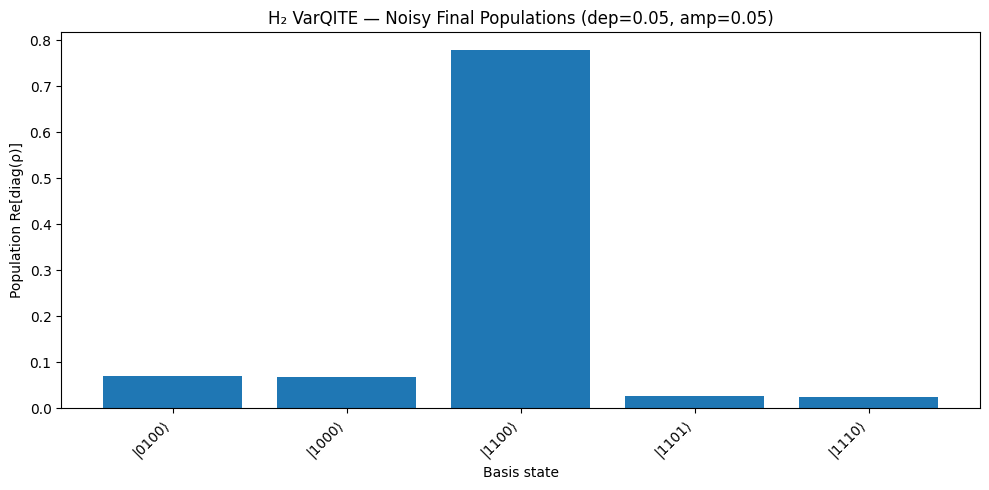

In [5]:
diag = np.clip(np.real(np.diag(rho)), 0.0, None)

threshold = 1e-2
index = np.where(diag > threshold)[0]

terms = [f"({diag[i]:.4f}|{i:0{num_qubits}b}⟩)" for i in index]
print(f"\nSignificant populations (diag(ρ) > {threshold:g}):")
print("  " + (" + ".join(terms) if terms else "(none above threshold)"))

labels = [f"|{i:0{num_qubits}b}⟩" for i in index]
vals = diag[index]

plt.figure(figsize=(10, 5))
plt.bar(labels, vals)
plt.xlabel("Basis state")
plt.ylabel("Population Re[diag(ρ)]")
plt.title(f"H₂ VarQITE — Noisy Final Populations (dep={depolarizing_prob}, amp={amplitude_damping_prob})")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 📈 Part 3 — Sweep Depolarizing Noise (Multi-Seed Statistics)

For each noise level, we:
- run VarQITE noiseless (cached) for that seed to obtain θ*
- evaluate Tr[ρ(θ*) H] under noise
- aggregate mean/std across seeds

In [ ]:
# Depolarizing noise sweep
p_dep_list = np.linspace(0.0, 0.10, 11)
seeds = list(range(5))

means, stds = [], []

for p in p_dep_list:
    Es = []

    for sd in seeds:
        r = run_qite(
            molecule=molecule_name,
            seed=int(sd),
            steps=int(steps),
            dtau=float(dtau),
            ansatz_name=ansatz,
            noisy=False,
            plot=False,
            show=False,
            force=False,
            fd_eps=float(fd_eps),
            reg=float(reg),
            solver=str(solver),
            pinv_rcond=float(pinv_rcond),
        )

        th_shape = tuple(r["final_params_shape"])
        th = np.array(r["final_params"], dtype=float).reshape(th_shape)

        dev = make_device(int(qubits), noisy=True)

        ans_fn, _ = build_ansatz(
            ansatz,
            int(qubits),
            seed=int(sd),
            symbols=symbols,
            coordinates=coordinates,
            basis=str(basis).lower(),
            requires_grad=False,
            hf_state=hf,
        )

        E_q = make_energy_qnode(
            H,
            dev,
            ans_fn,
            int(qubits),
            noisy=True,
            depolarizing_prob=float(p),
            amplitude_damping_prob=0.0,
            noise_model=None,
            symbols=symbols,
            coordinates=coordinates,
            basis=str(basis).lower(),
        )

        Es.append(float(E_q(th)))

    Es = np.asarray(Es, dtype=float)
    means.append(float(Es.mean()))
    stds.append(float(Es.std(ddof=1)) if len(Es) > 1 else 0.0)

means = np.asarray(means, dtype=float)
stds = np.asarray(stds, dtype=float)

print("\nSweep complete.")
for p, m, s in zip(p_dep_list, means, stds):
    print(f"p={p:0.3f} -> {m: .10f} ± {s:.10f}")


📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/qite/qite__H2__UCCSD__jordan_wigner__noiseless__steps75__dtau0.1__s0__3632340576c0.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/qite/qite__H2__UCCSD__jordan_wigner__noiseless__steps75__dtau0.1__s1__778dd410251e.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/qite/qite__H2__UCCSD__jordan_wigner__noiseless__steps75__dtau0.1__s2__5fe32f9b17f2.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/qite/qite__H2__UCCSD__jordan_wigner__noiseless__steps75__dtau0.1__s3__7ca85f90434b.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/qite/qite__H2__UCCSD__jordan_wigner__noiseless__steps75__dtau0.1__s4__f0d542113953.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/qite/qite__H2__UCCSD__jordan_wigner__noiseless__steps75__dtau0.1__s0__3632340576c0.json

📂 Found cached 

# 📊 Plot — Energy vs Depolarizing Probability

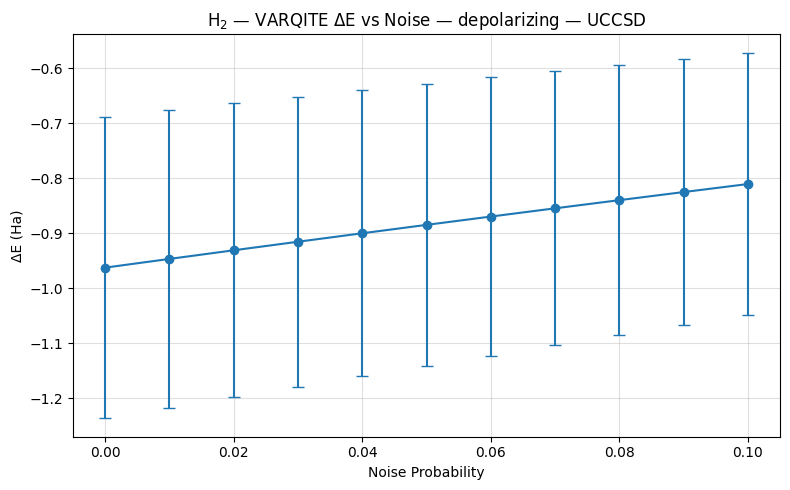

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/qite/H2/noise_stats_UCCSD_noise_scan_dep.png


In [7]:
plot_noise_statistics(
    p_dep_list,
    means,
    stds,
    fidelity_mean=None,
    fidelity_std=None,
    molecule=molecule_name,
    method="VarQITE",
    ansatz=ansatz,
    noise_type="depolarizing",
    seed=int(seed),
    show=True,
    save=True,
)